In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000
#gamma=0.99
gamma=0.85
egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval=10

score_to_solve = 195

In [9]:
env = gym.make('CartPole-v1')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,number_of_outputs)
        
    def forward(self, x):
        output = self.linear1(x)
        return output

samplenn=NeuralNetwork().to(device)

state = env.reset()

state=torch.Tensor(state).to(device)
state

samplenn(state)

sample_loss_function= nn.MSELoss()

action=env.action_space.sample()
new_state, reward, done, info = env.step(action)
#state=torch.Tensor(state).to(device)
new_state=torch.Tensor(new_state).to(device)
reward=torch.Tensor([reward]).to(device)

new_state_values=samplenn(new_state).detach()
max_new_state_values=torch.max(new_state_values)
target_value=reward + gamma*max_new_state_values

target_value

predicted_value=samplenn(state)[action].view((-1))

predicted_value

sample_loss_function(predicted_value,target_value)

ttest=torch.Tensor([2,4,6])

i=torch.argmax(ttest)

i

ttest[i].item()

In [14]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor([reward]).to(device)
        
        
        if done:
            target_value=reward
        else:
            self.nn.eval()
            new_state_values=self.nn(new_state).detach()
            max_new_state_values=torch.max(new_state_values)
            target_value=reward + gamma*max_new_state_values
        
        self.nn.train()
        #the view call needed to make it a tensor
        predicted_value=self.nn(state)[action].view(-1)
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [15]:
qnet_agent=QNet_Agent()

In [16]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [17]:
%%time

num_episodes=1000

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        
        qnet_agent.optimize(state,
                            action,
                            new_state,
                            reward,
                            done)
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])/report_interval
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 1.81
Average over all episodes so far: 18.1
epsilon: 0.6134315694915909
**** Episode  20 **** 
Recent average reward: 1.44
Average over all episodes so far: 16.25
epsilon: 0.4569950673364404
**** Episode  30 **** 
Recent average reward: 1.6
Average over all episodes so far: 16.166666666666668
epsilon: 0.3469874880994002
**** Episode  40 **** 
Recent average reward: 1.05
Average over all episodes so far: 14.75
epsilon: 0.2850509064827379
**** Episode  50 **** 
Recent average reward: 1.0699999999999998
Average over all episodes so far: 13.94
epsilon: 0.2331341772395536
**** Episode  60 **** 
Recent average reward: 1.03
Average over all episodes so far: 13.333333333333334
epsilon: 0.19207353378749153
**** Episode  70 **** 
Recent average reward: 1.1099999999999999
Average over all episodes so far: 13.014285714285714
epsilon: 0.1594800956365593
**** Episode  80 **** 
Recent average reward: 1.1
Average over all episodes so far: 12.7625
epsilon: 

**** Episode  550 **** 
Recent average reward: 0.93
Reward over last 100: 9.47
Average over all episodes so far: 10.021818181818182
epsilon: 0.0200140929854313
**** Episode  560 **** 
Recent average reward: 0.9
Reward over last 100: 9.43
Average over all episodes so far: 10.003571428571428
epsilon: 0.020011724459163105
**** Episode  570 **** 
Recent average reward: 0.9800000000000001
Reward over last 100: 9.45
Average over all episodes so far: 10.0
epsilon: 0.020009656943462965
**** Episode  580 **** 
Recent average reward: 0.9400000000000001
Reward over last 100: 9.44
Average over all episodes so far: 9.989655172413793
epsilon: 0.020007985897602675
**** Episode  590 **** 
Recent average reward: 0.99
Reward over last 100: 9.47
Average over all episodes so far: 9.988135593220338
epsilon: 0.020006577647683123
**** Episode  600 **** 
Recent average reward: 0.95
Reward over last 100: 9.47
Average over all episodes so far: 9.98
epsilon: 0.020005428577811398
**** Episode  610 **** 
Recent av

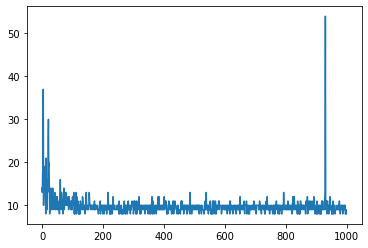

In [18]:
plt.plot(steps_total)
plt.show()

In [19]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 9.827


In [20]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 9.827
Average number of steps=reward in last 100 episodes: 9.82


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

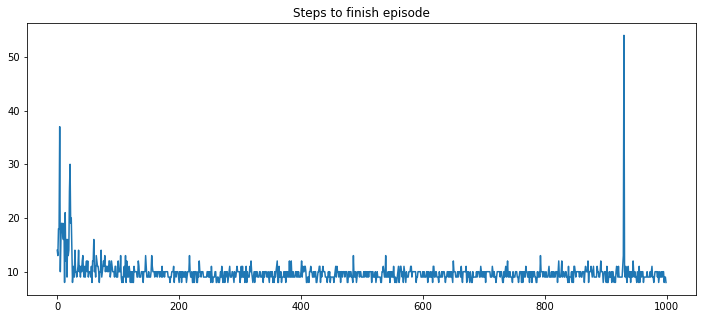

In [21]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()